# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from hrv_utils.utils import read_file
from hrv_utils.nongaussian import generate_nongaussian, nongaussian_analysis
from scipy.special import gamma
from scipy.signal import savgol_filter

# Non-Gaussian Intermittent Fluctuation Analysis

Adaptive behavior involves flexibly responding to task demands by balancing immediate and future needs, necessitating the ability to transition between tasks and constraints without being rigidly fixed in one approach. This capability to switch between different modes of activity represents a form of intermittency, which presents challenges in modeling, as it may appear incompatible with the rule-following nature of "internal" predictive models.

These intermittent behaviors defy a typical Gaussian distribution with short tails, instead exhibiting long and heavy tails due to their exploration of extreme regions beyond average goals. Unlike Gaussian distributions, which result from adding independent variables, intermittent behaviors are influenced by interactions between variables in cascades, leading to a lognormal distribution characterized by longer, heavier tails. This is due to nonlinear correlations resulting from multiplicative processes, such as cascades, highlighting the distinctive nature of intermittent behaviors compared to Gaussian distributions.

A one-dimensional discrete time series based on the idea of the multiplicative cascade can be constructed as follows: one starts with a discrete time series of Gaussian noise ${X_t}$ of length $2^m$ where m is the total number of cascade steps, and split the interval into two equal subintervals. On each subinterval, the local standard deviation (SD) is multiplied by random weights $e^Y$, where Y are independent Gaussian random variables with variance $\frac{\lambda^2}{m}$ and $\lambda \geq 0$ is a shape parameter controlling the strength of non-Gaussianity. Each of the two subintervals is again cut in two equal subintervals and the process is repeated. After m cascade steps, the time series ${b_t}$ is given by

$$b_t = X_t exp \sum_{j=1}^m Y^{(j)}_{\lfloor \frac{(t-1)}{2^{m-j}} \rfloor}$$

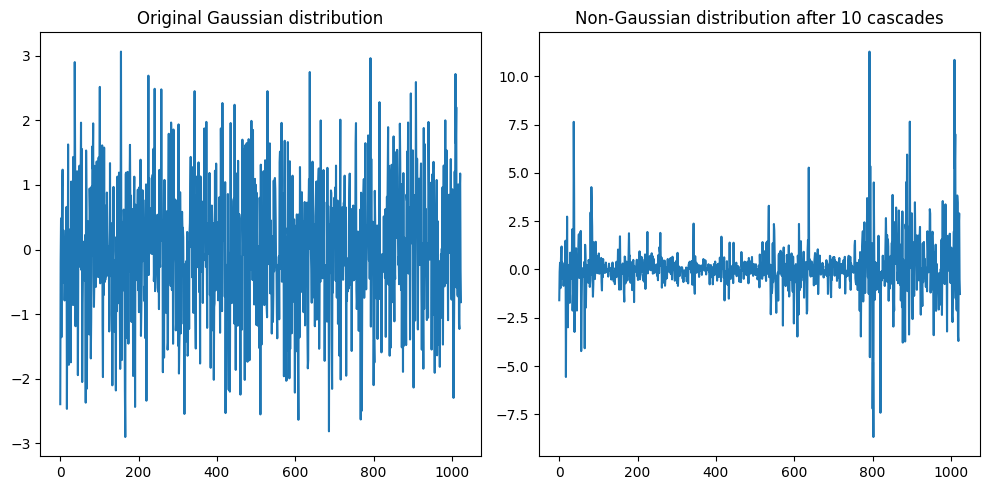

In [24]:
m = 10
samples = 2**m
variance = 0.7
std = np.sqrt(variance/m)

# Start with a series derived from a random normal distribution
series = np.random.default_rng().normal(0, 1, samples)

# Sample random exponenets for each of the samples at each of the levels
r = [
    np.random.default_rng().normal(0, std, 2**j) 
    for j in range(1, m)
]

# Define the independent gaussian random variables Y and compute the right handside of the equation
Y = np.exp(np.array([
    np.sum([r[k-1][math.floor(j/(2**(m-k)))]
            for k in range(1, m)])
    for j in range(2**m)
]))

# Compute the final output based on the equation above
b = series*Y

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(series)
ax1.set_title('Original Gaussian distribution')

ax2.plot(b)
ax2.set_title('Non-Gaussian distribution after 10 cascades')

fig.tight_layout()

The difference between the gaussian and non-gaussian series is clear, with the non-gaussian case having clear bursts of higher variation and periods of lower variation, while the gaussian seems to have a consistent variance all throughout. Now that we understand what kinds of mechanisms that can generate non-gaussian signals, the question of how to quantify and explain these intermittent fluctuations still remains. For this purpose, multiscale PDF analysis is going to be discussed here.

Firstly, we can see from our equation that the variance $\lambda^2$ is the parameter that gives rise to the non-gaussianity in this model, with larger $\lambda$ leading to higher intermittence (fatter tails) and $\lambda \xrightarrow[]{} 0$ actually converging to a standard normal distribution. This parameter can actually be estimated using a moment based estimator

$$\hat{\lambda}^2_q = \frac{2}{q(q-2)}\{\ln (\frac{\sqrt{\pi}\langle|x|^q\rangle}{2^{q/2}})-\ln \Gamma (\frac{q+1}{2})\}$$

for $q \neq 0, 2$ (for these two specific values of q, a modified equation is used). We can also compute the variance associated with Y(t) given by the log-amplitude based estimator

$$\hat{\lambda}^2 = \langle (\ln |x| - \langle \ln |x| \rangle)^2 \rangle - \frac{\pi^2}{8}$$

Their implementations are shown below



In [3]:
# Implementing the equation for the non-gaussian parameter lambda^2
def nongaussian_index(x, q):
    k = 2/(q*(q-2))
    a = np.log(np.sqrt(np.pi)*np.mean(np.abs(x)**q)/(2**(q/2)))
    b = np.log(gamma((q+1)/2))

    return k*(a-b)

# Implementing the equation for the non-gaussian parameter associated with the
# variance of Y(t)
def log_amplitude_fluctuation(x):
    return np.mean((np.log(np.abs(x))-np.mean(np.log(np.abs(x))))**2)-np.pi**2/8

Nongaussian parameter:  0.14
Nongaussian parameter 2:  0.69


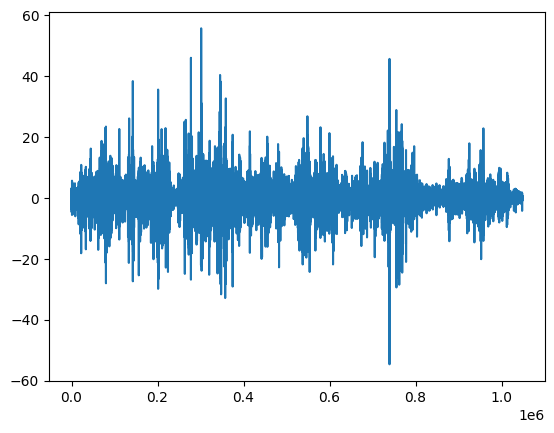

In [22]:
b = generate_nongaussian(20, 0.7)
plt.plot(b)

print(f'Nongaussian parameter: {nongaussian_index(b, 0.25): .2f}')
print(f'Nongaussian parameter 2: {log_amplitude_fluctuation(b): .2f}')

More than this, if we approximate the distribution of the local sum of our signal x(t) by a Gaussian, the non-Gaussian parameter $\lambda^2$ for a scale $s_n$ for this local sum can be given by 

$$\lambda^2=\mu_2^{(0)}(N-\log_2 s_n) \sim -\ln s$$

where $\mu_2^{(0)}$ is the variance of Y(t) that we obtained before and $\sim$ indicates proportionality.

Text(0.5, 0, 's')

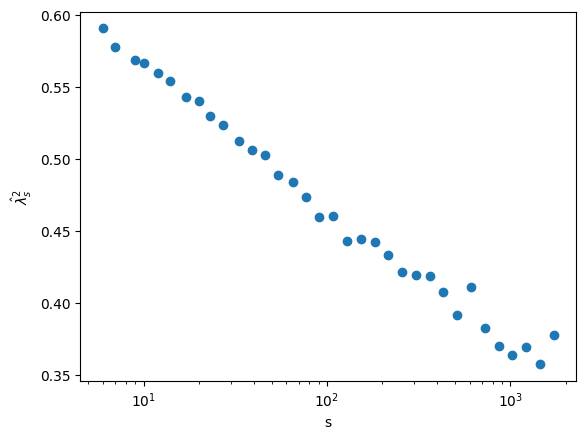

In [8]:
b = generate_nongaussian(20, 0.7)

y = np.cumsum(b-np.mean(b))

scales = [1+int(2**(i/4)) for i in range(10, 44)]
nongaussianity = []

for s in scales:
    e = y - savgol_filter(y, s, m)
    dy = e[s:]-e[:-s]

    dy = dy/np.std(dy)

    nongaussianity.append(nongaussian_index(dy, 0.25))

plt.scatter(scales, nongaussianity)
plt.xscale('log')
plt.ylabel(r"$\hat{\lambda}^2_s$")
plt.xlabel("s")

As we can see in this example, the series clearly has a inversely proportional relation with the logarithm of the scale, indicating the non-gaussianity. However, the non-Gaussian parameter is meaningful when considering the non-Gaussian shape within a multiplicative lognormal distribution framework, but in cases where this is not a valid assumption the relationship between $\hat{\lambda}_q^2$ is more complicated to interpret, requiring more careful analysis. To ensure that the relationship between $\lambda^2$ and ln s accurately reflects cascadelike intermittency,  it is important to acknowledge that other mechanisms can also give rise to non-gaussian patterns. To evaluate whether the observed relationship is actually associated with cascade-like processes we have to compare our results with surrogate series. One recommended way of doing that is via the iterated amplitude-adjusted Fourier transform (IAAFT) surrogate testing method. This method preserves the series linear autocorrelation and original values by preserving the amplitude spectrum and randomizing the phase spectrum. The process to generate a surrogate time series via IAAFT then follows these 4 steps:

1. Obtain the Fourier Transform of our series;
2. Shuffle the phase of the transform while keeping the amplitude intact;
3. Apply the inverse Fourier transform to obtain our surrogate series;
4. Align the histogram of the surrogate with the original series. This is done by ranking both the series from largest to smallest and replacing the j-th ranked value of the surrogate by the j-th ranked value in the original.
5. Iteratively refine the surrogate according to a user defined metric.

This generates a series with identical linear correlations to the original series, but lacks the original non-linear correlations.

In [3]:
# This code was taken from https://github.com/mlcs/iaaft
# Please refer to the original.
def surrogates(x, ns, tol_pc=5., verbose=True, maxiter=1E6, sorttype="quicksort"):
    """
    Returns iAAFT surrogates of given time series.

    Parameter
    ---------
    x : numpy.ndarray, with shape (N,)
        Input time series for which IAAFT surrogates are to be estimated.
    ns : int
        Number of surrogates to be generated.
    tol_pc : float
        Tolerance (in percent) level which decides the extent to which the
        difference in the power spectrum of the surrogates to the original
        power spectrum is allowed (default = 5).
    verbose : bool
        Show progress bar (default = `True`).
    maxiter : int
        Maximum number of iterations before which the algorithm should
        converge. If the algorithm does not converge until this iteration
        number is reached, the while loop breaks.
    sorttype : string
        Type of sorting algorithm to be used when the amplitudes of the newly
        generated surrogate are to be adjusted to the original data. This
        argument is passed on to `numpy.argsort`. Options include: 'quicksort',
        'mergesort', 'heapsort', 'stable'. See `numpy.argsort` for further
        information. Note that although quick sort can be a bit faster than 
        merge sort or heap sort, it can, depending on the data, have worse case
        spends that are much slower.

    Returns
    -------
    xs : numpy.ndarray, with shape (ns, N)
        Array containing the IAAFT surrogates of `x` such that each row of `xs`
        is an individual surrogate time series.

    See Also
    --------
    numpy.argsort

    """
    # as per the steps given in Lancaster et al., Phys. Rep (2018)
    nx = x.shape[0]
    xs = np.zeros((ns, nx))
    ii = np.arange(nx)

    # get the fft of the original array
    x_amp = np.abs(np.fft.fft(x))
    x_srt = np.sort(x)
    r_orig = np.argsort(x)

    for k in range(ns):
        # 1) Generate random shuffle of the data
        count = 0
        r_prev = np.random.permutation(ii)
        r_curr = r_orig
        z_n = x[r_prev]
        percent_unequal = 100.

        # core iterative loop
        while (percent_unequal > tol_pc) and (count < maxiter):
            r_prev = r_curr

            # 2) FFT current iteration yk, and then invert it but while
            # replacing the amplitudes with the original amplitudes but
            # keeping the angles from the FFT-ed version of the random
            y_prev = z_n
            fft_prev = np.fft.fft(y_prev)
            phi_prev = np.angle(fft_prev)
            e_i_phi = np.exp(phi_prev * 1j)
            z_n = np.fft.ifft(x_amp * e_i_phi)

            # 3) rescale zk to the original distribution of x
            r_curr = np.argsort(z_n, kind=sorttype)
            z_n[r_curr] = x_srt.copy()
            percent_unequal = ((r_curr != r_prev).sum() * 100.) / nx

            # 4) repeat until number of unequal entries between r_curr and 
            # r_prev is less than tol_pc percent
            count += 1

        if count >= (maxiter - 1):
            print("maximum number of iterations reached!")

        xs[k] = np.real(z_n)

    return xs

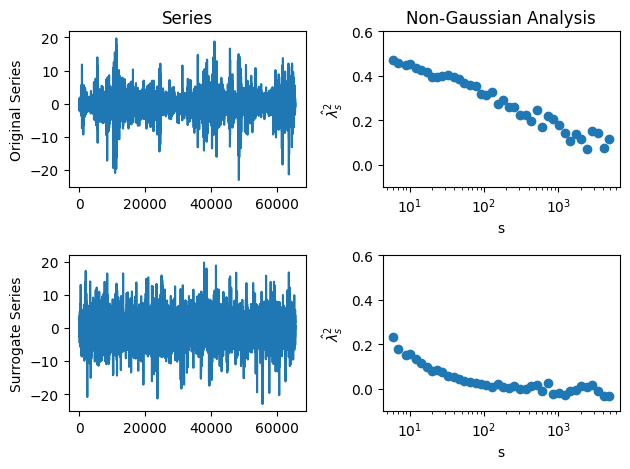

In [16]:
b = generate_nongaussian(16, 0.7)
surrogate = surrogates(b, 1)[0]

scales = [1+int(2**(i/4)) for i in range(10, 50)]
ng = nongaussian_analysis(b, scales)
ng2 = nongaussian_analysis(surrogate, scales)

fig, axs = plt.subplots(2,2)

axs[0][0].set_title('Series')
axs[0][1].set_title('Non-Gaussian Analysis')
axs[0][0].plot(b)
axs[0][0].set_ylabel("Original Series")
axs[0][1].scatter(scales, ng)
axs[0][1].set_xscale('log')
axs[0][1].set_ylabel(r"$\hat{\lambda}^2_s$")
axs[0][1].set_xlabel("s")

axs[1][0].plot(surrogate)
axs[1][1].scatter(scales, ng2)
axs[1][0].set_ylabel("Surrogate Series")
axs[1][1].set_xscale('log')
axs[1][1].set_ylabel(r"$\hat{\lambda}^2_s$")
axs[1][1].set_xlabel("s")

axs[0][1].set_ylim(-0.1, 0.6)
axs[1][1].set_ylim(-0.1, 0.6)

fig.tight_layout()

Now, multiscale PDF analysis involves detrending the nonstationary trends present in time series, which is crucial for preventing distortions in the PDF and maintaining the reproductive property. Many methods of detrended analysis use piecewise linear filters and polynomials, but because of their non-linearity they lack the reproductive property. To accomodate for that, we can use the Savitzky-Golay filter instead for the detrending process, as it is a linear filter. 

The Savitzky-Golay filter has 2 main parameters, the window size `s` and the polynomial order `m`, and we have the restriction that m must be an even number while s must be an odd number. By using it, the procedure for multiscale nongaussian analysis goes as follows:

1. Subtract the average from your signal so that it fluctuates around 0 ($x(t) = signal-\langle signal\rangle$).
2. Integrate the signal (cummulative sum, making $y(t) = \sum_{i=0}^t x(t)$).
3. For a given scale s:
    * Approximate the signal by using the Savitzky-Golay filter ($\hat{y}(t)$)
    * Subtract the approximated signal from the original ($e(t) = y(t)-\hat{y}(t)$)
    * Compute the increments ($\Delta_s y(t) = e(t+s)-e(t)$)
    * Standardize the values by dividing by the standard deviation
    * Compute $\hat{\lambda}^2$
    * Repeat for other values of s

Note here that if you want the scales to have temporal meaning it is important that the signal being analyzed have a constant sampling rate, so in the case of HRV it might be good to resample the series.

Text(0.5, 1.0, 'Distribution of increments for s = 5')

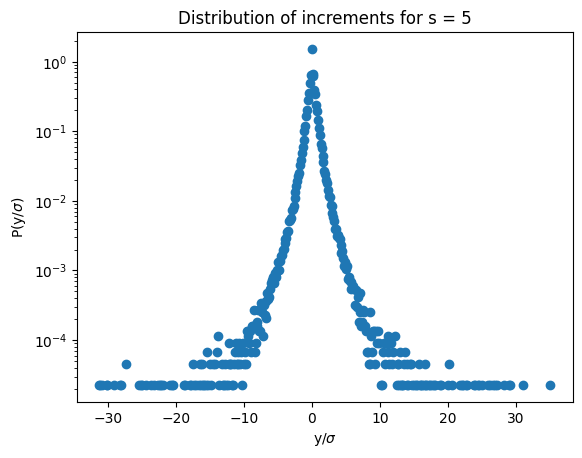

In [18]:
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate=4,
)

# Subtract average
x = hrv - np.mean(hrv)

# Integrate
y = np.cumsum(x)

# Fit savitzky-golay and subtract it from original series
s = 5
m = 2
e = y - savgol_filter(y, s, m)

# Compute increments
dy = e[s:]-e[:-s]

# Standardize
dy = dy/np.std(dy)

points, bins = np.histogram(dy, bins=500, density=True)

bins = (bins[1:]+bins[:-1])/2

plt.scatter(bins, points)
plt.yscale('log')
plt.xlabel(r"y/$\sigma$")
plt.ylabel(r"P(y/$\sigma$)")
plt.title(f'Distribution of increments for s = {s}')

Text(0.5, 0, 's')

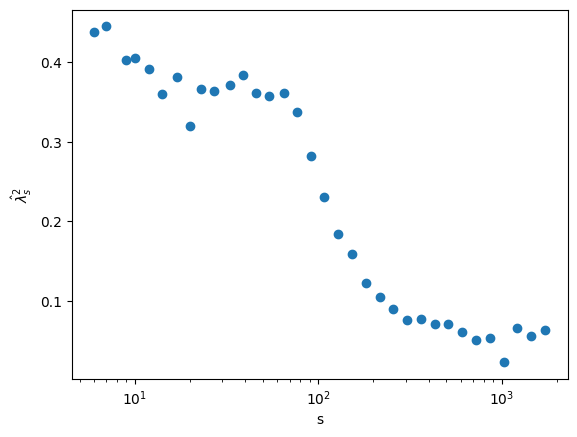

In [7]:
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate=4,
)

y = np.cumsum(hrv - np.mean(hrv))
m = 2

scales = [1+int(2**(i/4)) for i in range(10, 44)]
nongaussianity = []

for s in scales:
    e = y - savgol_filter(y, s, m)
    dy = e[s:]-e[:-s]

    dy = dy/np.std(dy)

    nongaussianity.append(nongaussian_index(dy, 0.25))

plt.scatter(scales, nongaussianity)
plt.xscale('log')
plt.ylabel(r"$\hat{\lambda}^2_s$")
plt.xlabel("s")



Here we can observe the inversely proportional relation between $\hat{\lambda}^2$ and $\ln s$ as was discussed previously. Using this method, Kiyono et al. reported robust scale-invariant properties in non-Gaussian distributions observed in healthy human HRV spanning the range of about 20–2000 beats, which were preserved not only in a quiescent condition, but also in a dynamic state where the mean level of the heart rate was dramatically changing. In addition, in patients with CHF, increased non-Gaussianity at scale of 40 beats of 24-hour ambulatory HRV predicts increased mortality risk, while none of the conventional HRV indices, including those reflecting vagal heart rate control, were predictive of death.

# Further Readings

The contents here were based of "Quantifying non-Gaussian intermittent fluctuations in physiology: Multiscale probability density function analysis using the Savitzky-Golay detrending" by Madhur Mangalam, Ken Kiyono, et al. For further information refer to the original paper. The reader can also refer to "Multiscale Analysis of Intensive Longitudinal Biomedical Signals and Its Clinical Applications" by Nakamura T. and Kiyono K.